# 1. 사전 준비

In [1]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import tensorflow as tf
import keras
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import stats

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.optimizers import SGD, Adam

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/smarcle_study_DACON/open_data/train.csv", index_col=0)
train['voted'] = train['voted'] 
test=pd.read_csv('/content/drive/My Drive/Colab Notebooks/smarcle_study_DACON/open_data/test_x.csv', index_col=0)
submission=pd.read_csv('/content/drive/My Drive/Colab Notebooks/smarcle_study_DACON/open_data/sample_submission.csv', index_col=0)  


In [4]:
train.head()

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,QfA,QfE,QgA,QgE,QhA,QhE,QiA,QiE,QjA,QjE,QkA,QkE,QlA,QlE,QmA,QmE,QnA,QnE,QoA,QoE,QpA,QpE,QqA,QqE,QrA,QrE,QsA,QsE,QtA,QtE,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,voted,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,5.0,539,2.0,586,4.0,1095,5.0,1142,4.0,1287,4.0,883,4.0,851,2.0,851,5.0,816,2.0,579,2.0,924,2.0,366,2.0,876,2.0,633,1.0,1115,30s,2,1,4,Female,1,3,White,Other,2,2,2,1,2,1,7,4,4,3,1,2,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,1
1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,3.0,2190,1.0,826,1.0,4082,5.0,1867,3.0,1264,5.0,2943,4.0,3927,1.0,4329,5.0,1828,1.0,1214,5.0,2414,5.0,1356,1.0,3039,4.0,4304,1.0,1346,20s,4,2,3,Female,1,1,Asian,Hindu,1,1,0,0,1,2,3,4,0,4,3,2,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,1
2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,1.0,531,4.0,1167,1.0,1016,3.0,2653,2.0,1569,5.0,998,5.0,2547,2.0,918,4.0,2153,2.0,1304,1.0,1131,5.0,937,4.0,1327,1.0,1170,1.0,1409,30s,3,1,3,Male,1,2,White,Other,2,3,1,5,3,4,2,6,1,3,2,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1
3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,357,2.0,1519,4.0,159,3.0,2275,5.0,2809,4.0,5614,3.0,3219,4.0,1296,4.0,9046,4.0,1216,4.0,1169,4.0,23868,3.0,581,4.0,8830,4.0,2392,5.0,1312,20s,4,2,0,Female,1,1,Asian,Hindu,2,4,1,1,1,3,1,3,1,3,3,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1
4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,1014,2.0,628,1.0,991,1.0,1259,5.0,1153,5.0,1388,5.0,740,5.0,1181,4.0,547,2.0,575,1.0,754,4.0,1140,5.0,323,5.0,1070,1.0,583,2.0,1889,20s,3,1,2,Male,1,2,White,Agnostic,1,1,1,6,0,2,0,6,2,6,1,1,0,1,0,1,1,0,1,1,1,1,1,0,1,1,1,1


In [5]:
#voted = 0 , unvoted = 1 으로 바꿔주기
train.voted = train.voted - 1

In [6]:
Answers_time = ['QaE', 'QbE', 'QcE', 'QdE', 'QeE',
             'QfE', 'QgE', 'QhE', 'QiE', 'QjE', 
             'QkE', 'QlE', 'QmE', 'QnE', 'QoE', 
             'QpE', 'QqE', 'QrE', 'QsE', 'QtE', 'voted']

In [7]:
Answers_time_only = ['QaE', 'QbE', 'QcE', 'QdE', 'QeE',
             'QfE', 'QgE', 'QhE', 'QiE', 'QjE', 
             'QkE', 'QlE', 'QmE', 'QnE', 'QoE', 
             'QpE', 'QqE', 'QrE', 'QsE', 'QtE']

## 마키아벨리니즘 스코어 적용

부호 column 같은 경우

+이면 답변값이 높을수록 마키아벨리니즘 성향이 높은 것이고

-이면 답변값이 낮을수록 마키아벨리니즘 성향이 높은 것입니다.

In [8]:
Answers = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA',
             'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
             'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 
             'QpA', 'QqA', 'QrA', 'QsA', 'QtA']
# Train dataset
# data reverse
flipping_columns = ["QeA", "QfA", "QkA", "QqA", "QrA"]
for flip in flipping_columns: 
    train[flip] = 6 - train[flip]
# secret data reverse
flipping_secret_columns = ["QaA", "QdA", "QgA", "QiA", "QnA"]
for flip in flipping_secret_columns: 
    train[flip] = 6 - train[flip]

# 각 index 별로 총 소요시간을 더해 평균 내기
train['Mach_score'] = train[Answers].mean(axis = 1)

In [9]:
train.head(5)

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,QfA,QfE,QgA,QgE,QhA,QhE,QiA,QiE,QjA,QjE,QkA,QkE,QlA,QlE,QmA,QmE,QnA,QnE,QoA,QoE,QpA,QpE,QqA,QqE,QrA,QrE,QsA,QsE,QtA,QtE,age_group,education,engnat,familysize,gender,hand,married,race,religion,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10,urban,voted,wf_01,wf_02,wf_03,wr_01,wr_02,wr_03,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13,Mach_score
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,5.0,1024,4.0,1577,1.0,539,4.0,586,4.0,1095,1.0,1142,4.0,1287,2.0,883,4.0,851,2.0,851,1.0,816,2.0,579,2.0,924,4.0,366,4.0,876,2.0,633,1.0,1115,30s,2,1,4,Female,1,3,White,Other,2,2,2,1,2,1,7,4,4,3,1,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,1,1,2.95
1,1.0,647,5.0,1313,3.0,3387,1.0,2969,5.0,4320,3.0,2190,5.0,826,1.0,4082,1.0,1867,3.0,1264,1.0,2943,4.0,3927,1.0,4329,1.0,1828,1.0,1214,5.0,2414,1.0,1356,5.0,3039,4.0,4304,1.0,1346,20s,4,2,3,Female,1,1,Asian,Hindu,1,1,0,0,1,2,3,4,0,4,3,1,0,0,0,0,1,0,1,1,0,1,1,0,1,0,1,1,2.60
2,2.0,1623,1.0,1480,1.0,1021,2.0,3374,1.0,1333,5.0,531,2.0,1167,1.0,1016,3.0,2653,2.0,1569,1.0,998,5.0,2547,2.0,918,2.0,2153,2.0,1304,1.0,1131,1.0,937,2.0,1327,1.0,1170,1.0,1409,30s,3,1,3,Male,1,2,White,Other,2,3,1,5,3,4,2,6,1,3,2,0,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1,1.90
3,3.0,504,3.0,2311,4.0,992,3.0,3245,5.0,357,4.0,1519,2.0,159,3.0,2275,1.0,2809,4.0,5614,3.0,3219,4.0,1296,4.0,9046,2.0,1216,4.0,1169,4.0,23868,3.0,581,2.0,8830,4.0,2392,5.0,1312,20s,4,2,0,Female,1,1,Asian,Hindu,2,4,1,1,1,3,1,3,1,3,3,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,3.35
4,5.0,927,1.0,707,5.0,556,4.0,1062,5.0,1014,4.0,628,5.0,991,1.0,1259,1.0,1153,5.0,1388,1.0,740,5.0,1181,4.0,547,4.0,575,1.0,754,4.0,1140,1.0,323,1.0,1070,1.0,583,2.0,1889,20s,3,1,2,Male,1,2,White,Agnostic,1,1,1,6,0,2,0,6,2,6,1,0,0,1,0,1,1,0,1,1,1,1,1,0,1,1,1,1,3.00


In [10]:
#Test dataset
#data reverse
flipping_columns = ["QeA", "QfA", "QkA", "QqA", "QrA"]
for flip in flipping_columns: 
    test[flip] = 6 - test[flip]
#secret data reverse
flipping_secret_columns = ["QaA", "QdA", "QgA", "QiA", "QnA"]
for flip in flipping_secret_columns: 
    test[flip] = 6 - test[flip]

test['Mach_score'] = test[Answers].mean(axis = 1)

##log_transformation of answer time

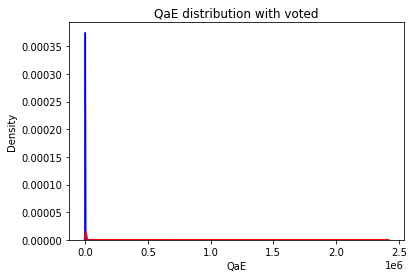

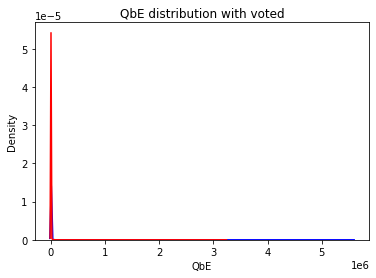

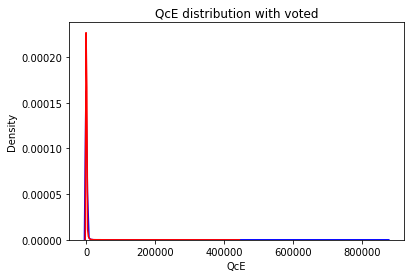

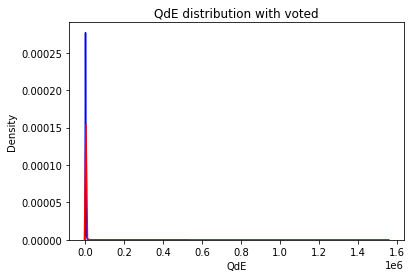

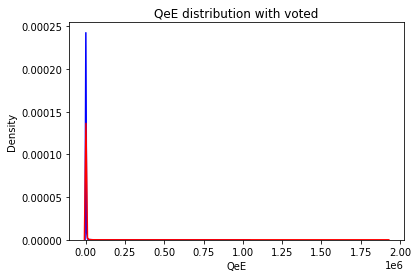

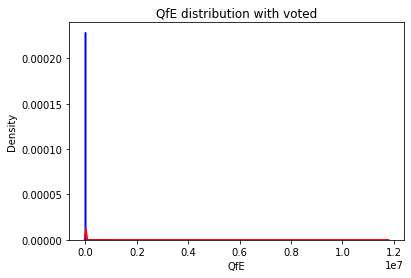

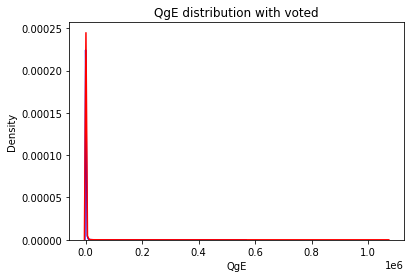

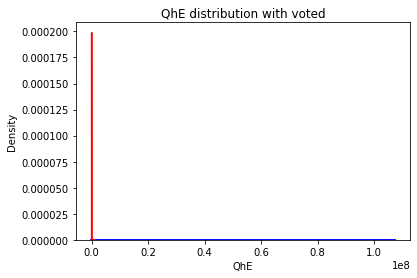

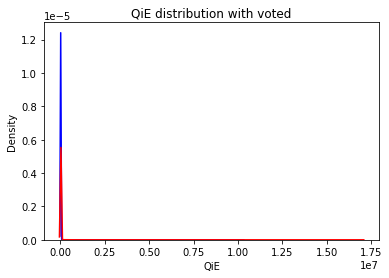

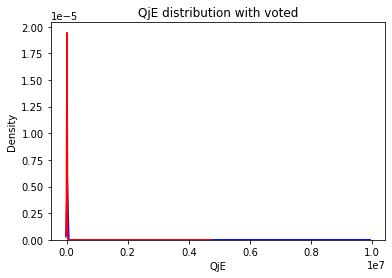

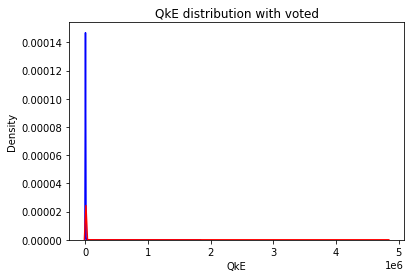

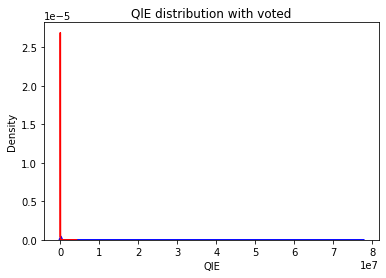

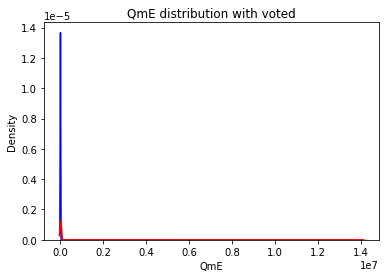

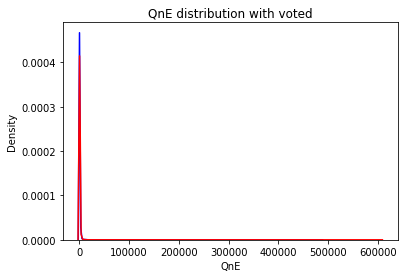

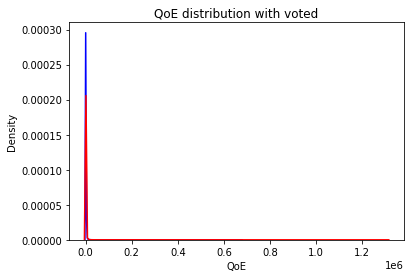

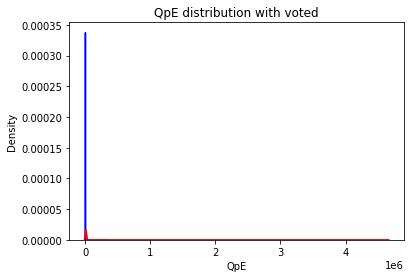

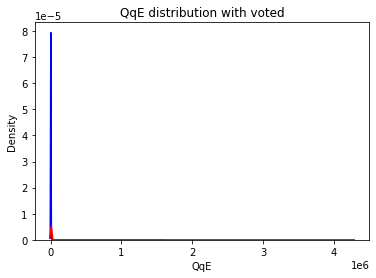

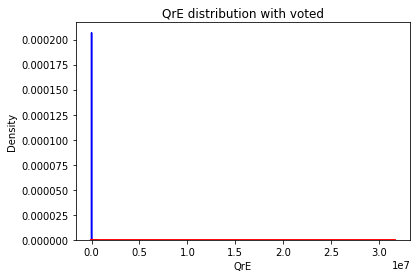

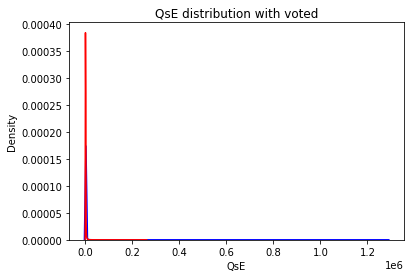

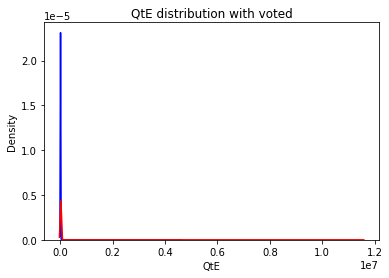

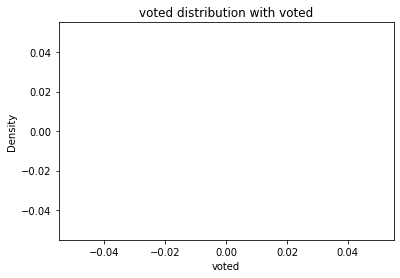

In [11]:
for i in Answers_time:
  sns.kdeplot(train[i][train.voted == 0], color = 'b', label = "voted")
  sns.kdeplot(train[i][train.voted == 1], color = 'r', label = "unvoted")
  plt.title(i + ' distribution with voted')
  plt.show()
  

In [12]:
log_Answer_time = train[Answers_time_only].copy()
# np.log1p(x) : 입력 array에 대해 자연로그 log(1 + x) 값을 반환합니다.
log_Answer_time[Answers_time_only] = np.log1p(train[Answers_time_only])
train[Answers_time_only] = log_Answer_time

In [13]:
log_Answer_time_t = test[Answers_time_only].copy()
# np.log1p(x) : 입력 array에 대해 자연로그 log(1 + x) 값을 반환합니다.
log_Answer_time_t[Answers_time_only] = np.log1p(test[Answers_time_only])
test[Answers_time_only] = log_Answer_time_t

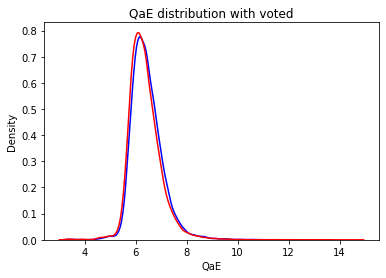

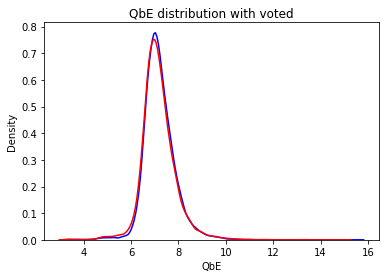

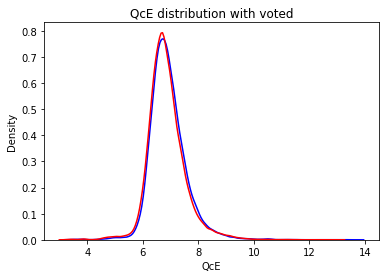

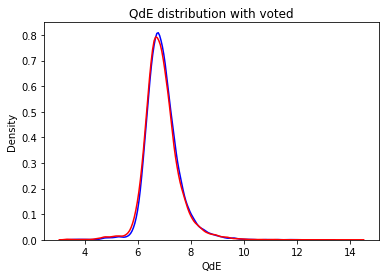

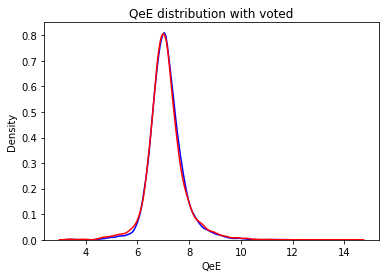

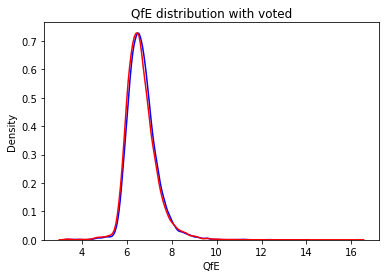

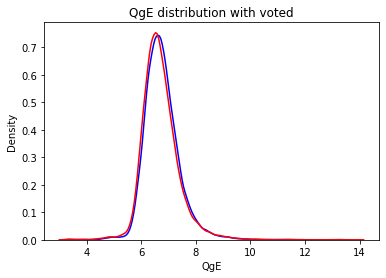

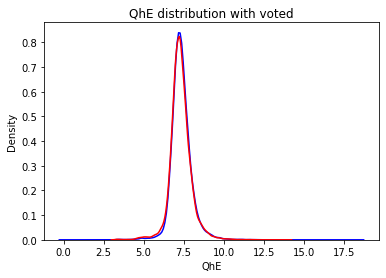

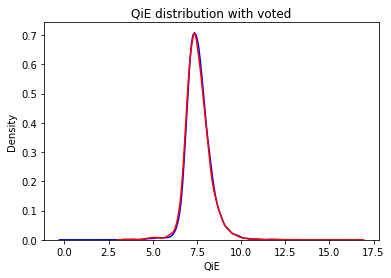

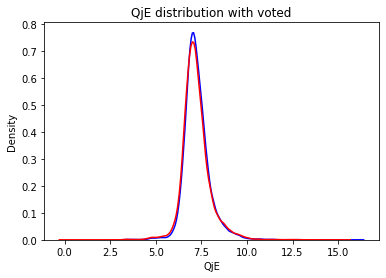

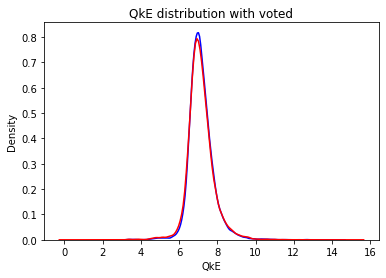

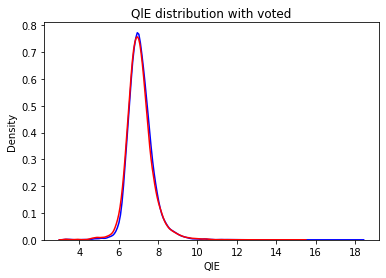

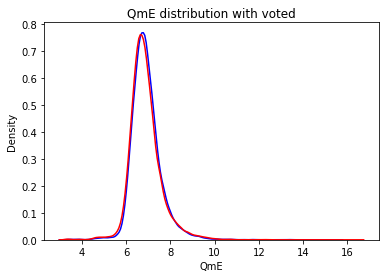

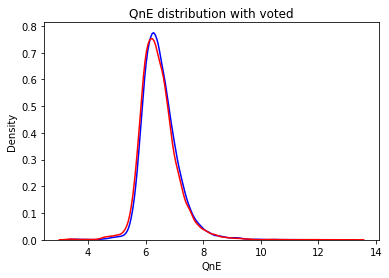

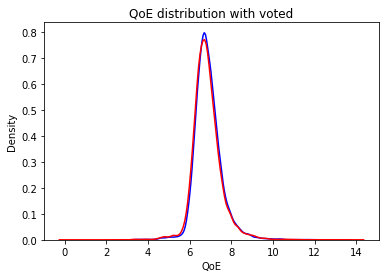

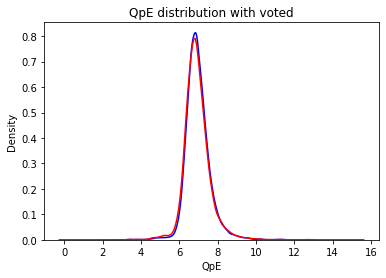

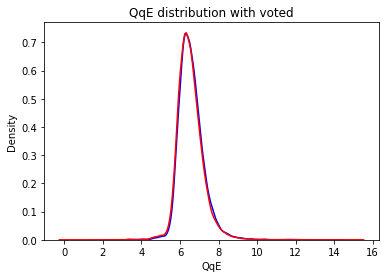

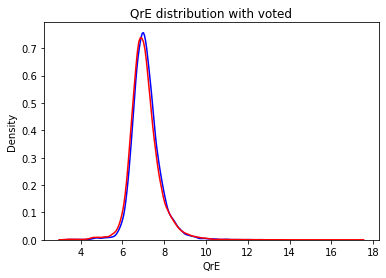

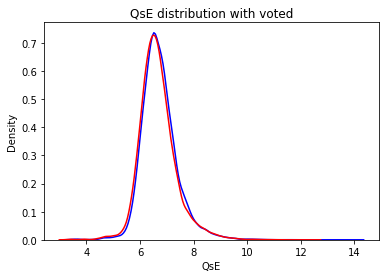

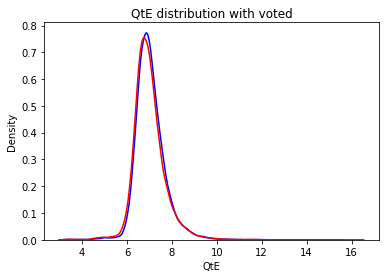

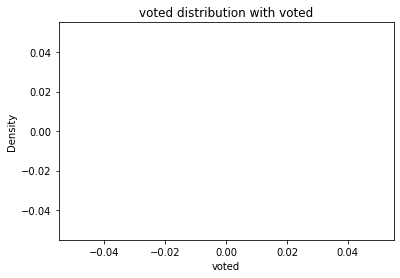

In [14]:
#after log
for i in Answers_time:
  sns.kdeplot(train[i][train.voted == 0], color = 'b', label = "voted")
  sns.kdeplot(train[i][train.voted == 1], color = 'r', label = "unvoted")
  plt.title(i + ' distribution with voted')
  plt.show()



극단적으로 치우져있던 데이터가 예쁘게 정리된것을 확인 할 수 있다.
성능도 현재 사용한 모델에서는 로그를 취했을 때 더 좋게 나온다.

#2. EDA

## 2-1. 결측치 데이터 확인

In [15]:
# 결측치 확인
print('train : ',train.isnull().sum())
print('test : ',test.isnull().sum())

train :  QaA           0
QaE           0
QbA           0
QbE           0
QcA           0
             ..
wr_10         0
wr_11         0
wr_12         0
wr_13         0
Mach_score    0
Length: 78, dtype: int64
test :  QaA           0
QaE           0
QbA           0
QbE           0
QcA           0
             ..
wr_10         0
wr_11         0
wr_12         0
wr_13         0
Mach_score    0
Length: 77, dtype: int64


## 2-2. category featues encoding

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45532 entries, 0 to 45531
Data columns (total 78 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   QaA         45532 non-null  float64
 1   QaE         45532 non-null  float64
 2   QbA         45532 non-null  float64
 3   QbE         45532 non-null  float64
 4   QcA         45532 non-null  float64
 5   QcE         45532 non-null  float64
 6   QdA         45532 non-null  float64
 7   QdE         45532 non-null  float64
 8   QeA         45532 non-null  float64
 9   QeE         45532 non-null  float64
 10  QfA         45532 non-null  float64
 11  QfE         45532 non-null  float64
 12  QgA         45532 non-null  float64
 13  QgE         45532 non-null  float64
 14  QhA         45532 non-null  float64
 15  QhE         45532 non-null  float64
 16  QiA         45532 non-null  float64
 17  QiE         45532 non-null  float64
 18  QjA         45532 non-null  float64
 19  QjE         45532 non-nul

In [17]:
pd.get_dummies(train['race'],prefix='race')

,race_Arab,race_Asian,race_Black,race_Indigenous Australian,race_Native American,race_Other,race_White
index,,,,,,,
0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
45527,0,0,0,0,0,0,1
45528,0,0,0,0,0,0,1
45529,0,0,0,0,0,0,1


In [18]:
label = LabelEncoder()
train['gender_code'] = label.fit_transform(train['gender'])
train['age_group_code'] = label.fit_transform(train['age_group'])
# get_dummies: 사실이 아닌 관계성으로 인해 잘못된 학습이 일어날 수 있으므로
#              더미로 만든 가변수로 변환해서 각 변환값 사이에 사칙연산이 불가능하게끔
# prefix: 변수이름
# join : 합치다 / join = 'Inner' : 두 DataFrame의 기준 컬럼에서 둘 다 존재하는 데이터만 Join                                         
train = pd.concat([train, pd.get_dummies(train['race'], prefix= 'race')], axis = 1, join = 'inner')
train = pd.concat([train, pd.get_dummies(train['religion'], prefix= 'religion')], axis = 1, join = 'inner')

test['gender_code'] = label.fit_transform(test['gender'])
test['age_group_code'] = label.fit_transform(test['age_group'])
test = pd.concat([test, pd.get_dummies(test['race'], prefix= 'race')], axis = 1, join = 'inner')
test = pd.concat([test, pd.get_dummies(test['religion'], prefix= 'religion')], axis = 1, join = 'inner')



##2-3. outlier handling

In [19]:
train = train.drop(train[train.familysize >= 20].index)

##2-4. check data distribution

### 2-4-1. category features EDA

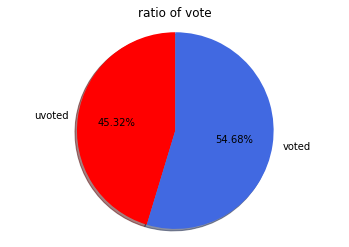

In [20]:
plt.pie((train.groupby(train['voted']).size()),
        labels = ['uvoted', 'voted'],
        shadow = True,
        colors = ['r', 'royalblue'],
        autopct='%0.2f%%',
        startangle=90
        )
plt.title("ratio of vote")
plt.axis('equal')
plt.show()

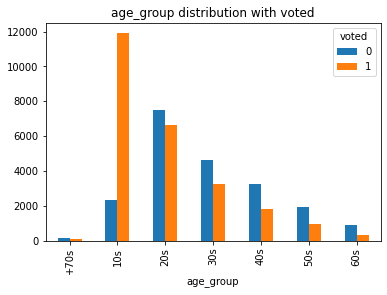

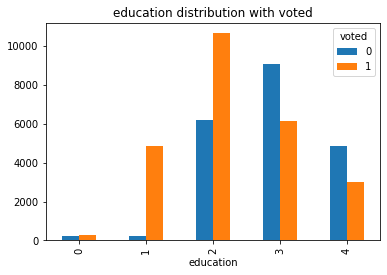

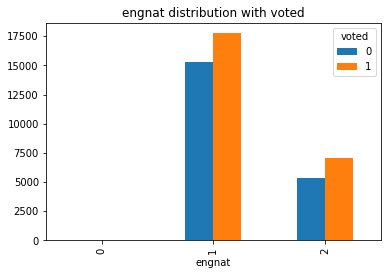

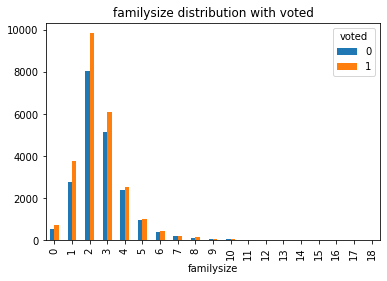

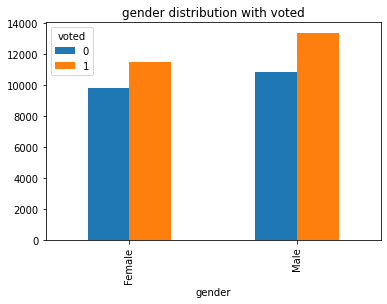

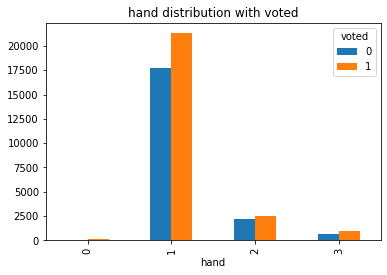

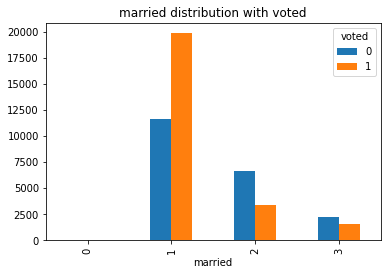

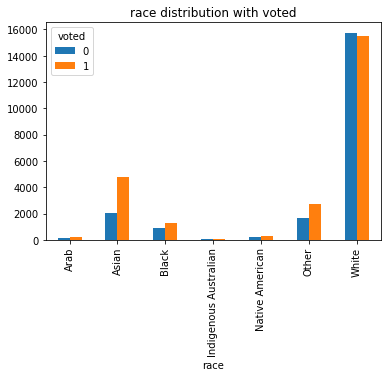

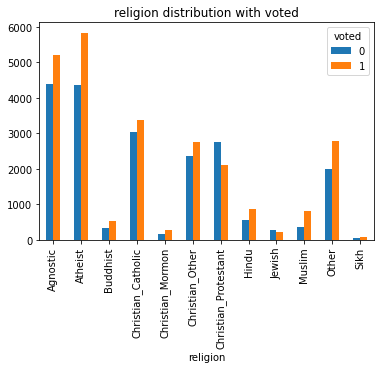

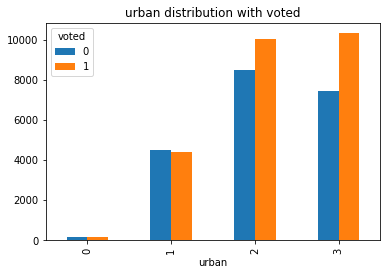

In [21]:
cat_features = ['age_group', 'education', 'engnat', 'familysize', 'gender', 'hand',
       'married', 'race', 'religion', 'urban']

for i in cat_features:
  #crosstab : 범주형 데이터의 각 개수 파악을 하기 위한 용도
  pd.crosstab(train[i],train['voted']).plot.bar()
  plt.title(i + ' distribution with voted')

# 0: 투표 yes / 1: 투표 no

# education: (1: 고등교육 미만 / 2: 고등학교 졸업 / 3: 학사 / 4: 석사 / 0: 무응답)
# engnat: 모국어가 영어 (1: 그렇다 / 2: 아니다 / 0: 무응답)
# hand : (1: 오른손잡이 / 2: 왼손잡이 / 3: 양손잡이 / 0: 무응답)
# married: (1: 미혼 / 2: 기혼 / 3: 이전에 결혼 / 0: 기타)
# urban: 유년기의 거주 구역
#         (1=Rural (country side), 2=Suburban, 3=Urban (town, city), 0=무응답)

### 2-4-2.countless features EDA

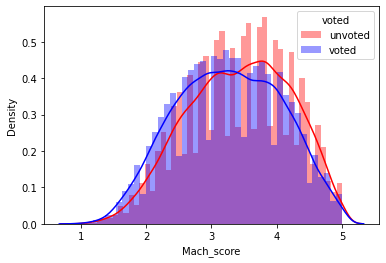

In [22]:
# 설문문항에 소요된 응답 시간 평균에 따른 사람들의 투표 여부

sns.distplot(train.Mach_score[train.voted == 1], color = 'red', label = "unvoted")
sns.distplot(train.Mach_score[train.voted == 0], color = 'b', label = "voted")

plt.legend(title = 'voted')
plt.show()

# 3.Model Tuning

## XGB Model

라벨인코더로 변환 후 새 column에 저장했기 때문에 기존 column은 삭제

In [23]:
train = train.drop(['age_group', 'gender', 'race', 'religion'], axis = 1)
test = test.drop(['age_group', 'gender', 'race', 'religion'], axis = 1)

Scaler 적용

In [24]:
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()

train[Answers_time_only] = Scaler.fit_transform(train[Answers_time_only])
test[Answers_time_only] = Scaler.fit_transform(test[Answers_time_only])

DMatrix 변환 : XGBoost에서 사용하는 내부 데이터 구조

In [25]:
ros = RandomOverSampler()

X = train.drop('voted', axis = 1).values
y = train.voted.values

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state= 0)
x_train, y_train= ros.fit_resample(x_train, y_train)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(test.values)

print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape )

(39878, 94) (9104, 94) (39878,) (9104,)


XGB Model

In [26]:
params = {
        'objective':'binary:logistic', # 학습 작업과 해당 학습 대상을 지정하거나 사용할 사용자 지정 목적 함수
        'max_depth':5,
        'learning_rate':0.1, 
        'eval_metric':'auc', # 사용자 지정 평가 메트릭
        'min_child_weight':8, # 인스턴스 가중치 최소 합계
        'subsample':0.8,
        'colsample_bytree':0.8,
        'seed':29,
        'reg_alpha':0, # 가중치에 대한 L1 정규화 항 (xgb의 알파).
        'gamma':1,
        'scale_pos_weight':1, # 양수 및 음수 가중치의 균형
        'n_estimators': 100,
        'nthread':-1 # 병렬화를 적용할 수 있을 때 데이터를 로드하는데 사용할 스레드 수
}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
nrounds=10000  
model_xgb = xgb.train(params, d_train, nrounds, watchlist, early_stopping_rounds=50, 
                           maximize=True, verbose_eval=10)

[0]	train-auc:0.757984	valid-auc:0.752193
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.77179	valid-auc:0.759671
[20]	train-auc:0.778092	valid-auc:0.762773
[30]	train-auc:0.784062	valid-auc:0.763347
[40]	train-auc:0.78996	valid-auc:0.763297
[50]	train-auc:0.796479	valid-auc:0.763785
[60]	train-auc:0.8023	valid-auc:0.764012
[70]	train-auc:0.808483	valid-auc:0.763746
[80]	train-auc:0.814707	valid-auc:0.764303
[90]	train-auc:0.818844	valid-auc:0.764155
[100]	train-auc:0.822798	valid-auc:0.76426
[110]	train-auc:0.826143	valid-auc:0.764206
[120]	train-auc:0.831514	valid-auc:0.764636
[130]	train-auc:0.834829	valid-auc:0.764272
[140]	train-auc:0.838375	valid-auc:0.764274
[150]	train-auc:0.841748	valid-auc:0.764267
[160]	train-auc:0.845763	valid-auc:0.763804
[170]	train-auc:0.848189	valid-auc:0.763482
Stopping. Best iteration:
[120]	train-auc:0.831514	valid-auc:0.764636



In [27]:
pred_y1 = model_xgb.predict(d_test) + 1

In [28]:
submission['voted'] = pred_y1

In [30]:
submission.to_csv('submission.csv')

# public점수 - 0.7737387126
# private점수 - 0.7703359106